In [52]:
import numpy as np
from pathlib import Path
import os
import re
import h5py
import pandas as pd
import logging
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

from graspy.plot import pairplot, heatmap
from lol import LOL
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from scipy.stats import multiscale_graphcorr, ttest_rel, ttest_ind
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

import sys; sys.path.append('../')
from src.tools import get_files, get_latents, align

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datadir = Path("/mnt/ssd3/ronan/data")
unaligned_dmap_dir = datadir / f"dmap_09-04_unaligned"
aligned_dmap_dir = datadir / f"dmap_09-22_aligned"
aligned_normed_dmap_dir = datadir / f"dmap_09-23_aligned_normed"
external_dir = Path('../data/external')

In [10]:
def center_distmat(distx):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]
    exp_distx = (
        np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
        + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
        - distx.sum() / ((n - 1) * (n - 2))
    )
    cent_distx = distx - exp_distx
    np.fill_diagonal(cent_distx, 0)
    return cent_distx

In [11]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()

def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed = 1,
    title = None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 4, subplot_kw={'projection': '3d'}, figsize=(res_scale*5, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    
    plt.subplots_adjust(wspace=0, hspace=0)        

    for i,ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / 'lh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[:len(cortex_left)]

        plotting.plot_surf_stat_map(fsa5.infl_left, 
          conn_map, hemi='left', colorbar=False, cmap='RdBu_r', axes = ax[0],
          vmax=vmax, symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_left,
          conn_map, hemi='left', colorbar=False, cmap='RdBu_r', view='medial', axes=ax[1], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

        cortex_right = nib.freesurfer.read_label(external_dir / 'rh.cortex.label')

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left):]

        plotting.plot_surf_stat_map(fsa5.infl_right, 
          conn_map, hemi='right', colorbar=False, cmap='RdBu_r', axes = ax[2], 
           vmax=vmax,symmetric_cbar=symmetric_cbar)

        plotting.plot_surf_stat_map(fsa5.infl_right,
          conn_map, hemi='right', colorbar=colorbar, cmap='RdBu_r', view='medial', axes=ax[3], 
            vmax=vmax,symmetric_cbar=symmetric_cbar)

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f'{str(save_path)}.png', format='png', bbox_inches='tight')
    else:
        return fig
#         plt.show()
#         plt.close(fig)
    
def make_cbar(vmax, save_path = None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.RdBu_r
    else:
        cmap = mpl.cm.Blues_R
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    #cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    
    #cb1.set_clim(vmin, vmax)
    #cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f'{str(save_path)}.pdf', bbox_inches='tight')
    plt.close(fig)

### Aligned

In [5]:
ALIGNED = True
NORMED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=False
)

<Figure size 432x288 with 0 Axes>

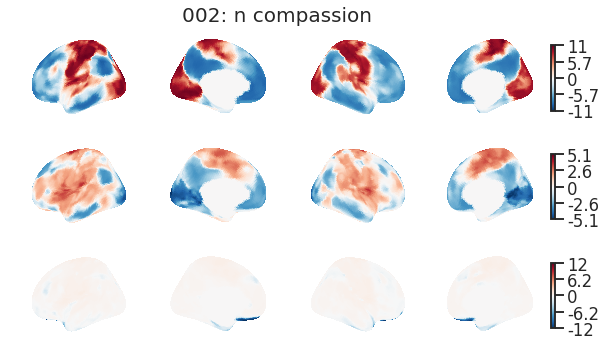

<Figure size 432x288 with 0 Axes>

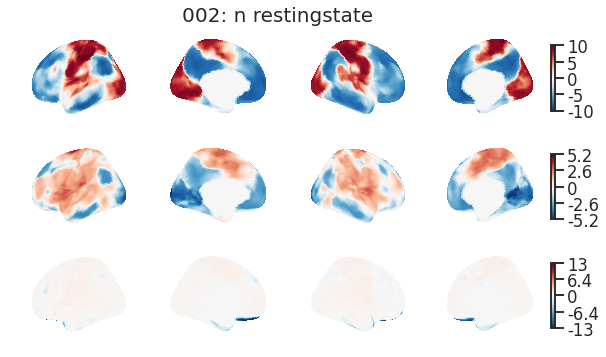

<Figure size 432x288 with 0 Axes>

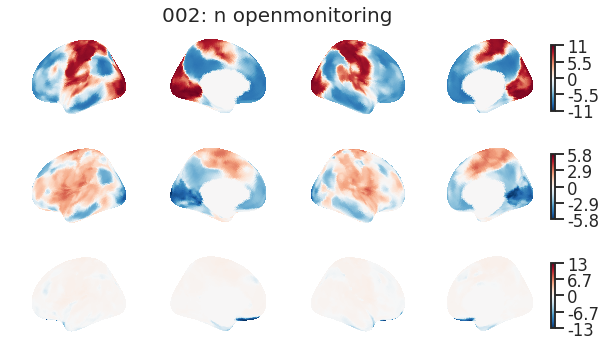

<Figure size 432x288 with 0 Axes>

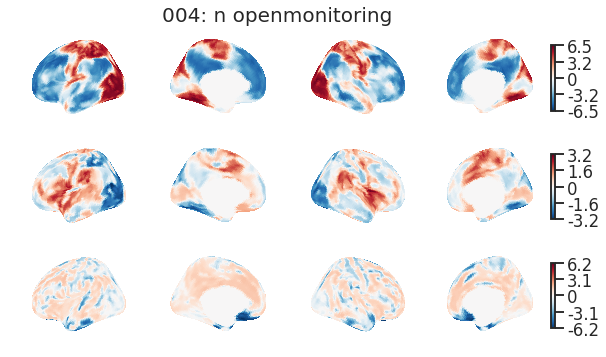

<Figure size 432x288 with 0 Axes>

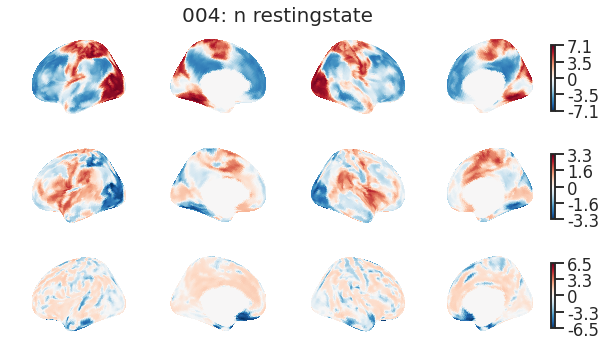

<Figure size 432x288 with 0 Axes>

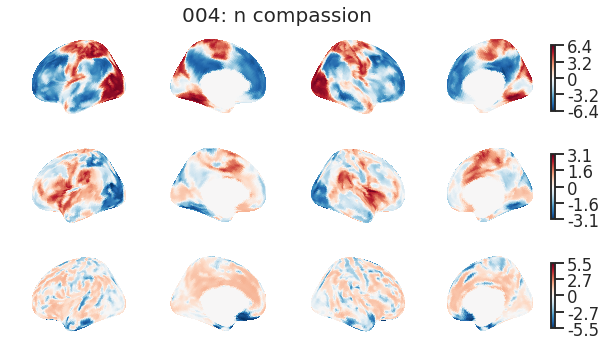

<Figure size 432x288 with 0 Axes>

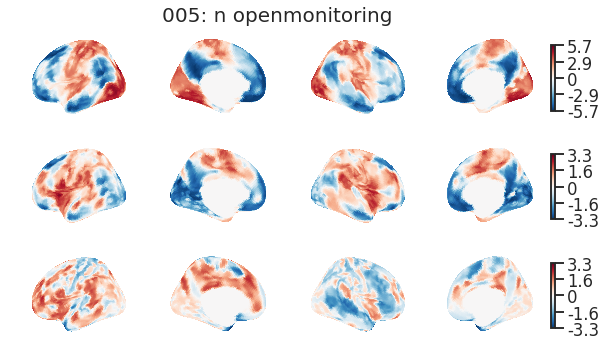

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [6]:
SAVE = False
COLORBAR = True
SHARED_COLORBAR = False
n_embed = 3

if SHARED_COLORBAR:
    vmax = np.max(np.abs(groups))
else:
    vmax = None
    
sort_idx = np.argsort(subjs)

for group, label, subj in zip(groups[sort_idx], labels[sort_idx], subjs[sort_idx]):
    if SAVE:
        title = False
    else:
        title = f"{subj}: {' '.join(label)}"
    visualize_embeddings(
        group,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_mean.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / f'{SOURCE}_{name}_colorbar')

### Unaligned

In [7]:
ALIGNED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=False, subjects_exclude=EXCLUDE_IDS
)

<Figure size 432x288 with 0 Axes>

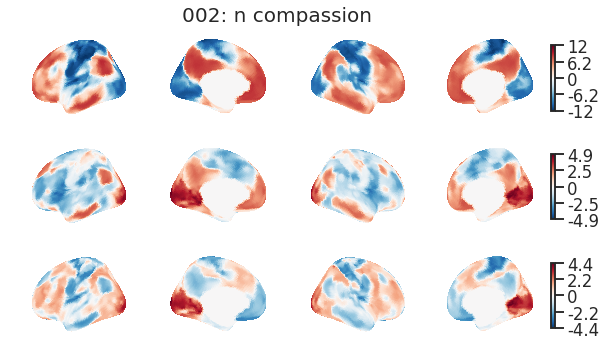

<Figure size 432x288 with 0 Axes>

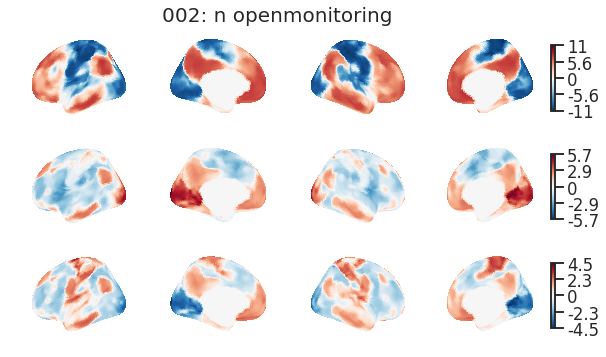

<Figure size 432x288 with 0 Axes>

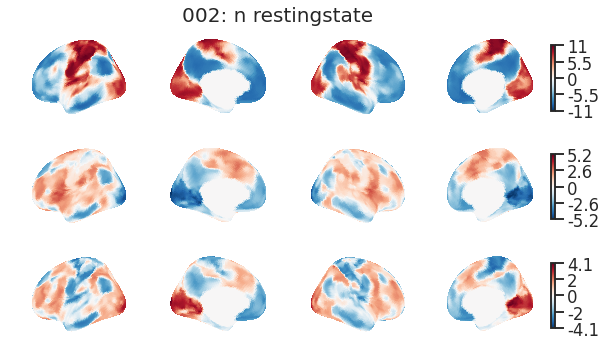

<Figure size 432x288 with 0 Axes>

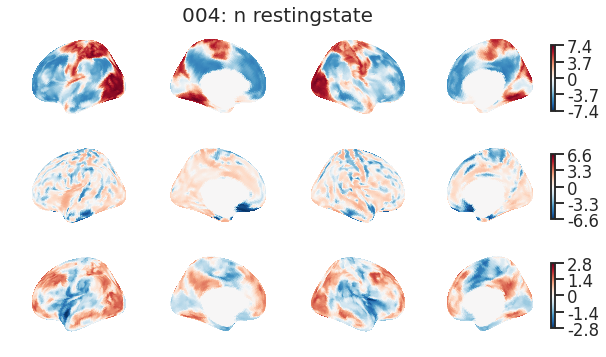

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [8]:
SAVE = False
COLORBAR = True
SHARED_COLORBAR = False
n_embed = 3

if SHARED_COLORBAR:
    vmax = np.max(np.abs(groups))
else:
    vmax = None
    
sort_idx = np.argsort(subjs)

for group, label, subj in zip(groups[sort_idx], labels[sort_idx], subjs[sort_idx]):
    if SAVE:
        title = False
    else:
        title = f"{subj}: {' '.join(label)}"
    visualize_embeddings(
        group,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_mean.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / f'{SOURCE}_{name}_colorbar')

### Aligned Normed

In [9]:
ALIGNED = True
NORMED = True
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=False, subjects_exclude=EXCLUDE_IDS
)

<Figure size 432x288 with 0 Axes>

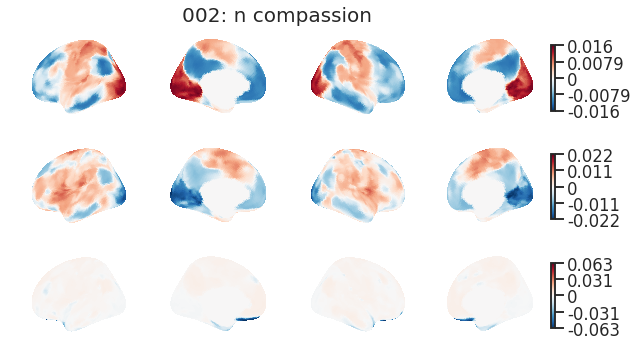

<Figure size 432x288 with 0 Axes>

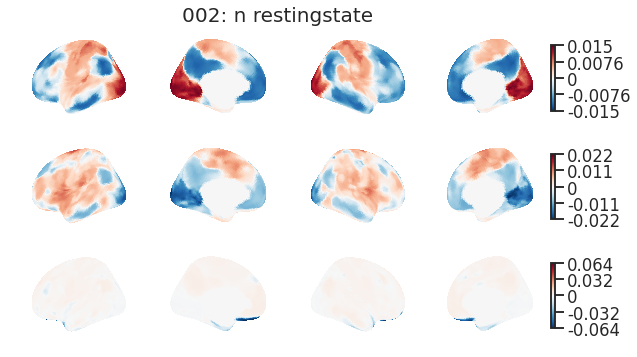

<Figure size 432x288 with 0 Axes>

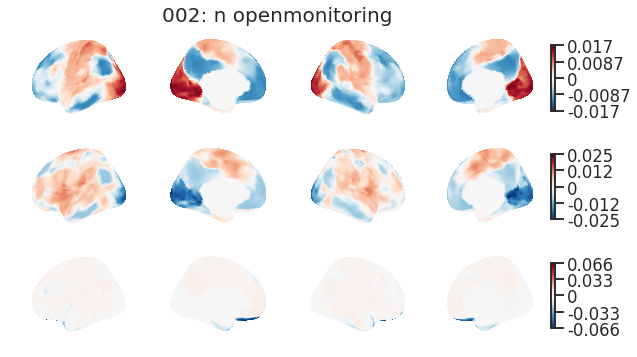

<Figure size 432x288 with 0 Axes>

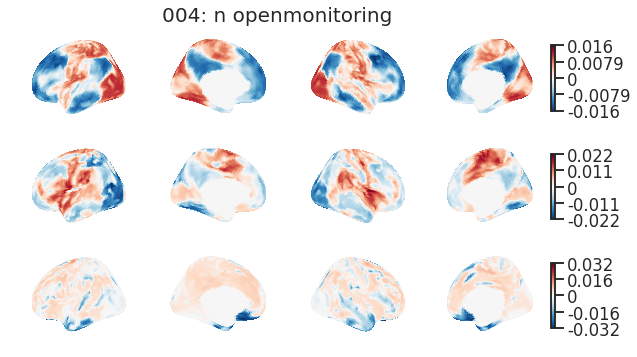

<Figure size 432x288 with 0 Axes>

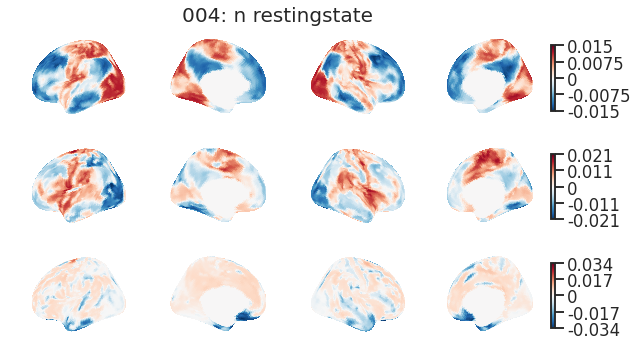

<Figure size 432x288 with 0 Axes>

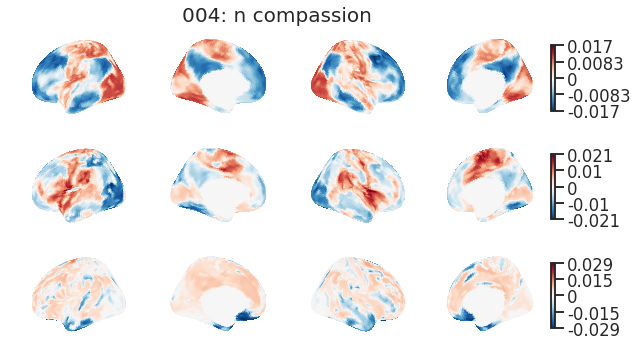

<Figure size 432x288 with 0 Axes>

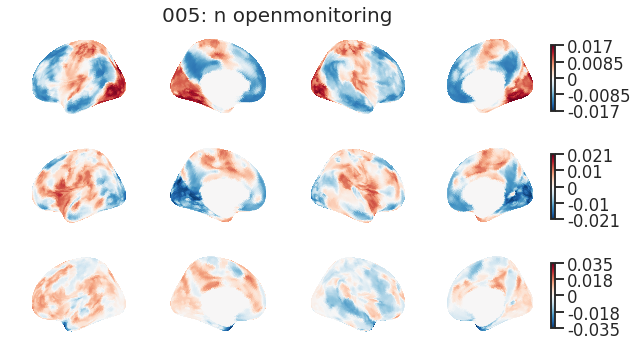

<Figure size 432x288 with 0 Axes>

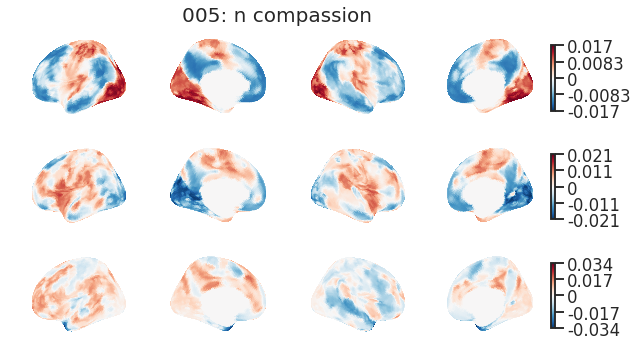

<Figure size 432x288 with 0 Axes>

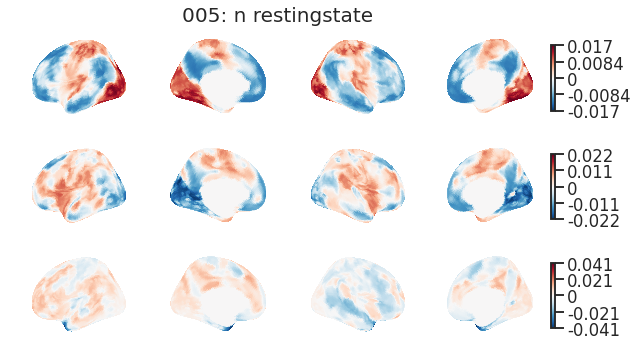

<Figure size 432x288 with 0 Axes>

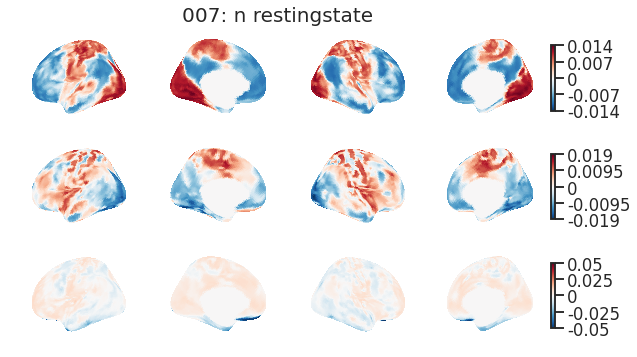

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [10]:
SAVE = False
COLORBAR = True
SHARED_COLORBAR = False
n_embed = 3

if SHARED_COLORBAR:
    vmax = np.max(np.abs(groups))
else:
    vmax = None
    
sort_idx = np.argsort(subjs)

for group, label, subj in zip(groups[sort_idx], labels[sort_idx], subjs[sort_idx]):
    if SAVE:
        title = False
    else:
        title = f"{subj}: {' '.join(label)}"
    visualize_embeddings(
        group,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_mean.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / f'{SOURCE}_{name}_colorbar')

### 5 loop align

In [77]:
ALIGNED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=False, subjects_exclude=EXCLUDE_IDS
)

In [85]:
def run_realign(emb, tar, firstpass = False):
    realign = []
    if firstpass:
        realign.append(tar)
    for i, embed in enumerate(emb):
        u, s, v = np.linalg.svd(tar.T.dot(embed), full_matrices=False)
        xfm = v.T.dot(u.T)
        realign.append(embed.dot(xfm))
    return realign

aligned_groups = []
for grad in [0,1,2]:
    embeddings = groups[:,:,grad][:,:,None]
    print(embeddings.shape)
    embeddings = run_realign(embeddings[1:], embeddings[0], firstpass=True)
    for i in range(5):
        embeddings = run_realign(embeddings, np.asarray(np.mean(embeddings, axis=0).squeeze()), firstpass = False)
    aligned_groups.append(embeddings)
aligned_groups = np.asarray(aligned_groups)

(225, 18715, 1)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [81]:
groups.shape

(225, 18715, 5)

<Figure size 432x288 with 0 Axes>

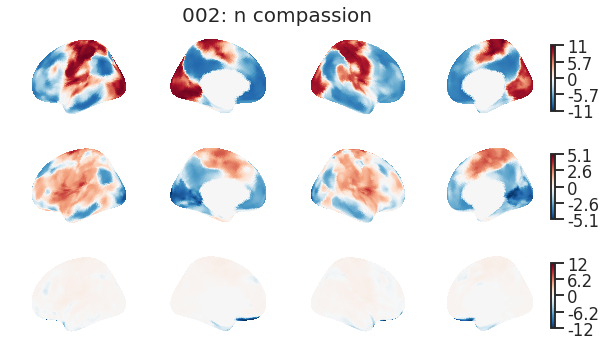

<Figure size 432x288 with 0 Axes>

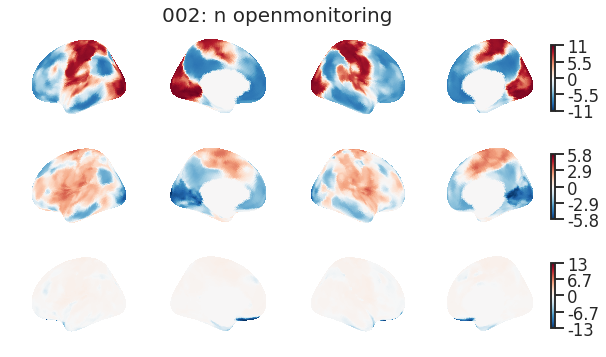

<Figure size 432x288 with 0 Axes>

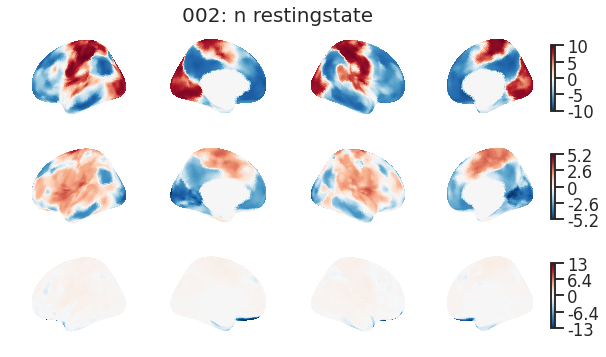

<Figure size 432x288 with 0 Axes>

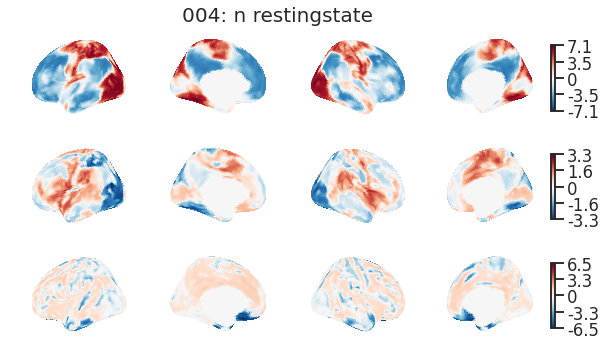

<Figure size 432x288 with 0 Axes>

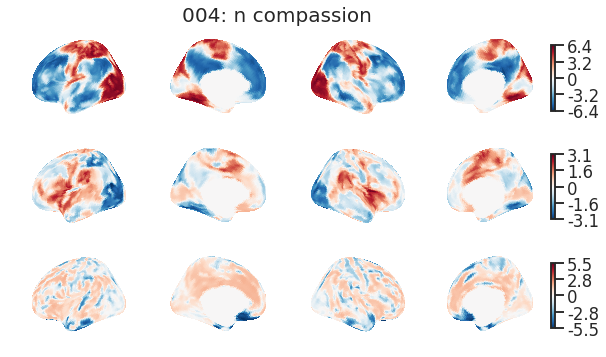

<Figure size 432x288 with 0 Axes>

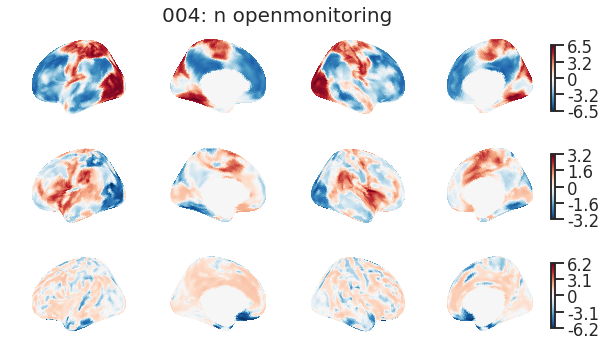

<Figure size 432x288 with 0 Axes>

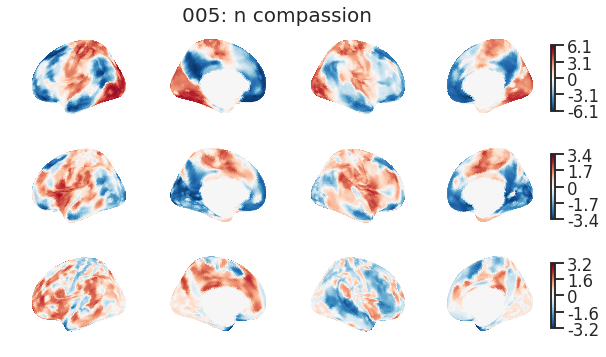

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [76]:
SAVE = False
COLORBAR = True
SHARED_COLORBAR = False
n_embed = 3

if SHARED_COLORBAR:
    vmax = np.max(np.abs(groups))
else:
    vmax = None
    
sort_idx = np.argsort(subjs)

for group, label, subj in zip(groups[sort_idx], labels[sort_idx], subjs[sort_idx]):
    if SAVE:
        title = False
    else:
        title = f"{subj}: {' '.join(label)}"
    visualize_embeddings(
        group,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=n_embed,
        vmax=vmax,
        title=title,
    )
    if SAVE:
        plt.savefig(save_dir / f'{SOURCE}_{name}_{grads}_mean.pdf', bbox_inches='tight', pad_inches = 0)
        plt.show()
    else:
        plt.show()

if SAVE and not COLORBAR:
    make_cbar(vmax, save_dir / f'{SOURCE}_{name}_colorbar')

### Distance map

In [3]:
ALIGNED = True
NORMED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=True
)

In [4]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

In [5]:
labels = np.hstack([[' '.join(label)]*len(g) for i,(label,g) in enumerate(zip(labels, groups)) if i in [0,2,3,5]])
groups = np.vstack([np.asarray(group) for group in np.asarray(groups, dtype=object)[[0,2,3,5]]])
subjs = np.hstack([subj for i,subj in enumerate(subjs) if i in [0,2,3,5]])

In [6]:
X = groups[:,:,1]

In [7]:
X_dists = pairwise_distances(X)

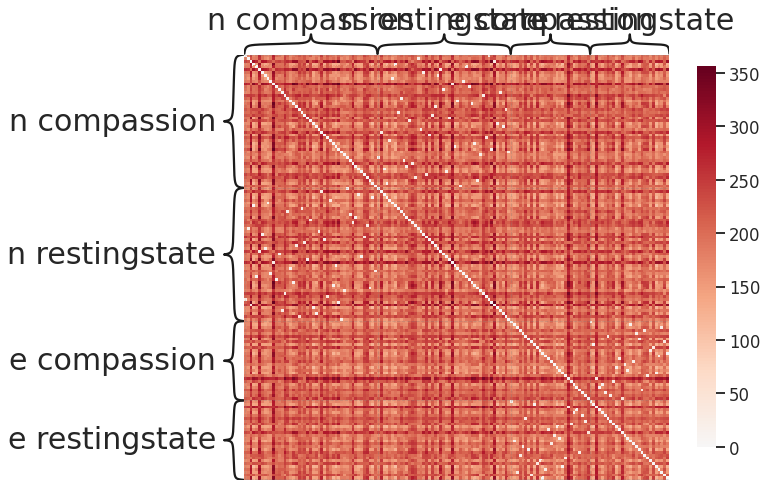

In [8]:
heatmap(X_dists, inner_hier_labels = labels)

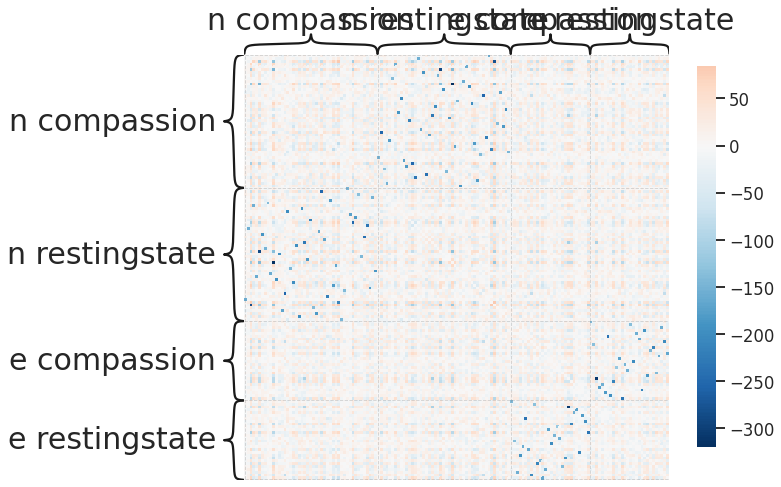

In [12]:
heatmap(center_distmat(X_dists), inner_hier_labels = labels)

In [13]:
from sklearn.manifold import MDS

In [24]:
dist_hat = MDS(n_components=3, dissimilarity="precomputed").fit_transform(
    X_dists
)

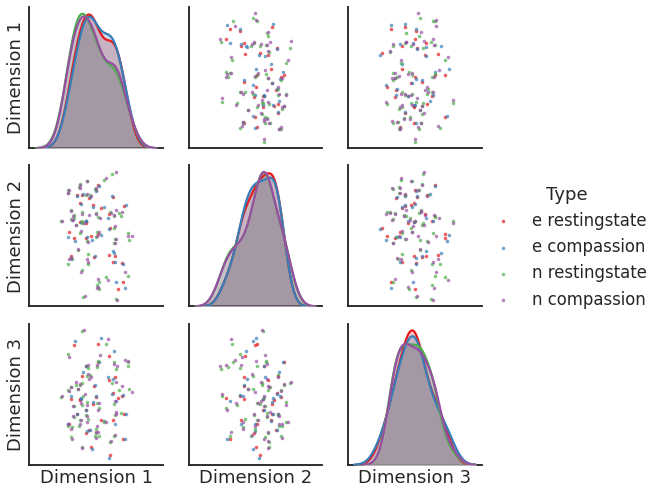

In [44]:
fig = pairplot(
    dist_hat, labels=labels, title=f"", context='talk'
)
plt.show()

In [50]:
dist_hat = MDS(n_components=5, dissimilarity="precomputed", metric=False).fit_transform(
    (center_distmat(X_dists) + center_distmat(X_dists).T) / 2
)

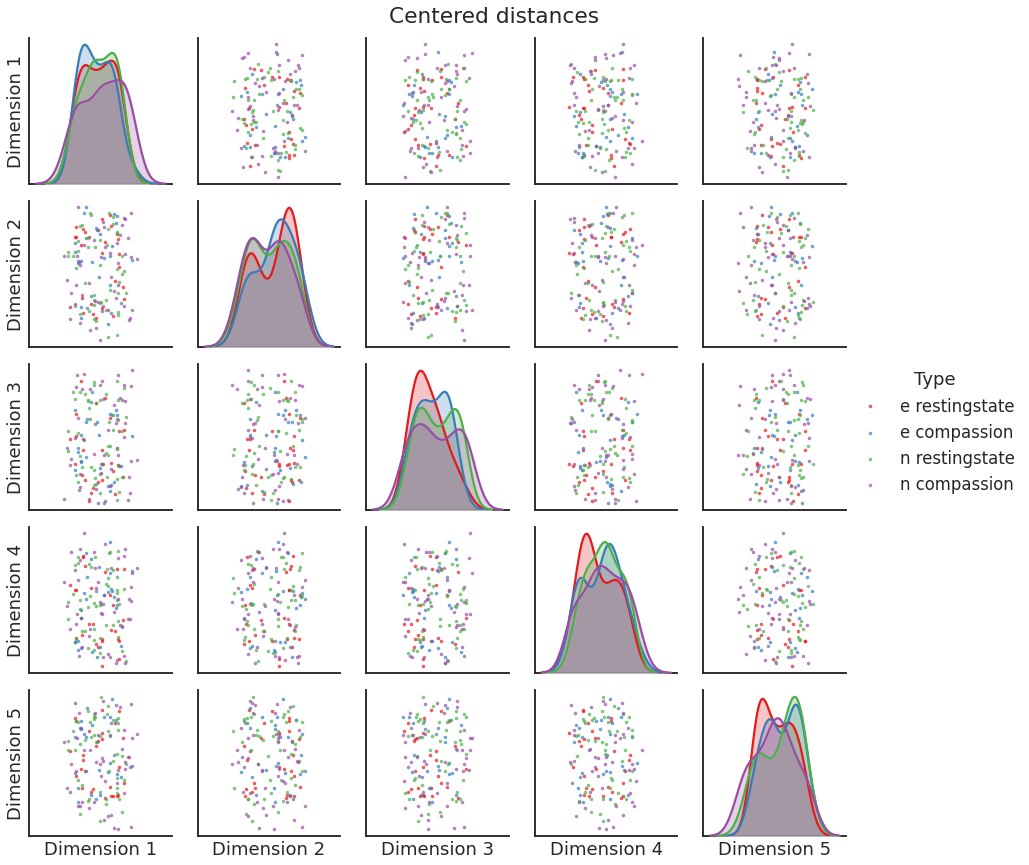

In [51]:
fig = pairplot(
    dist_hat, labels=labels, title=f"Centered distances", context='talk'
)
plt.show()

In [115]:
mean_distances = []
unique_labels = np.unique(labels)
for i, label in enumerate(labels):
    dists = []
    for ul in unique_labels:
        idx = np.where(labels == ul)[0]
        if ul[0] == label[0]:
            els = X_dists[i, idx]
            dists.append(np.sum(els) / (len(els) - 1))
        else:
            dists.append(np.mean(X_dists[i, idx]))
    mean_distances.append(dists)
mean_distances = np.asarray(mean_distances)

In [116]:
mean_distances.shape

(150, 4)

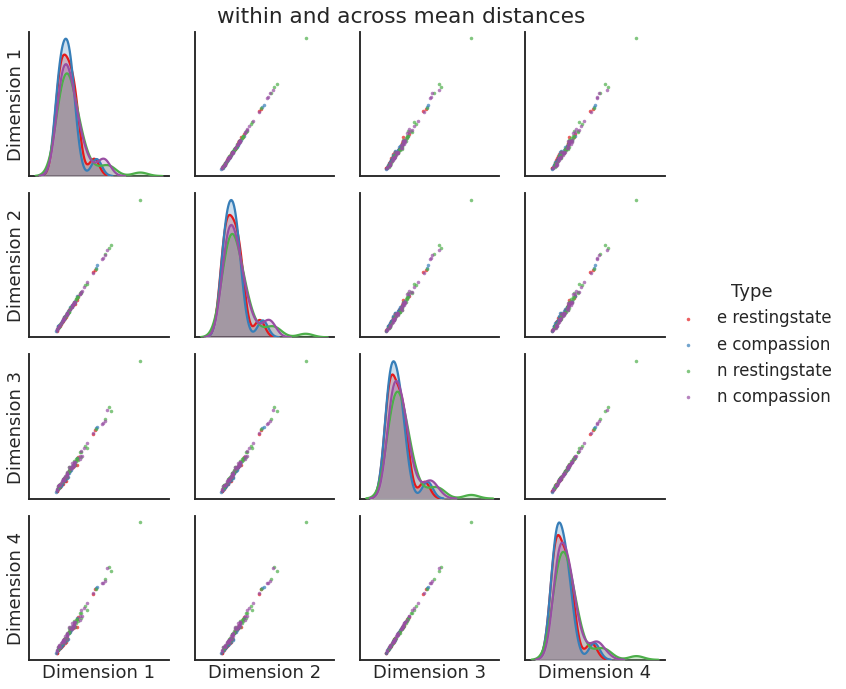

In [117]:
fig = pairplot(
    mean_distances, labels=labels, title=f"within and across mean distances",
)
plt.show()

(array([54., 49., 28.,  5.,  6.,  4.,  3.,  0.,  0.,  1.]),
 array([149.0619213 , 173.36439921, 197.66687712, 221.96935504,
        246.27183295, 270.57431087, 294.87678878, 319.1792667 ,
        343.48174461, 367.78422253, 392.08670044]),
 <a list of 10 Patch objects>)

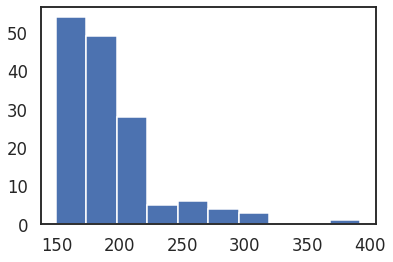

In [118]:
plt.hist(mean_distances[:,0])

In [119]:
np.argmax(mean_distances[:,0])

101

In [123]:
subjs[101]

'108'

### Group distributions
Experts and novices, resting state and compassion

In [19]:
ALIGNED = True
NORMED = False
EXCLUDE_IDS = ['073']

if ALIGNED:
    flag = "_dmap"
    ftype = "npy"
    SOURCE = 'dmap'
    if NORMED:
        source_dir = aligned_normed_dmap_dir
    else:
        source_dir = aligned_dmap_dir
#     groups, labels, subjs = get_latents(
#         source_dir, flag=flag, ids=True, ftype=ftype, as_groups=False, source=SOURCE
#     )
else:
    flag = "_emb"
    ftype = 'npy'
    SOURCE = 'dmap_raw'
    source_dir = unaligned_dmap_dir

groups, labels, subjs = get_latents(
    source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, as_groups=True
)

In [20]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

In [27]:
group_pairs = [(0,2), (0,3), (2,3), (3,5)]
gradient = 1

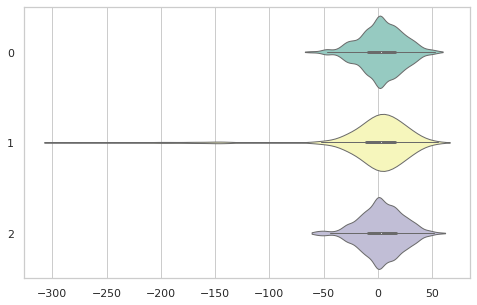

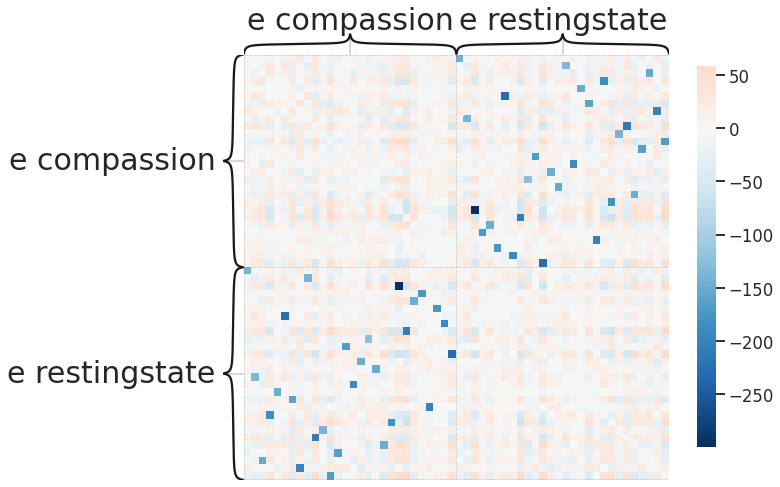

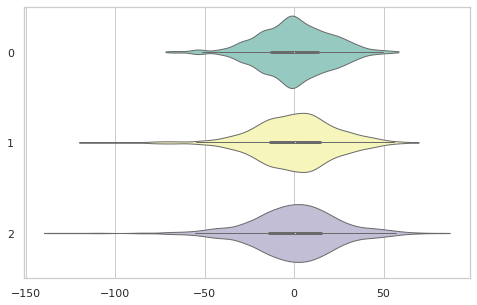

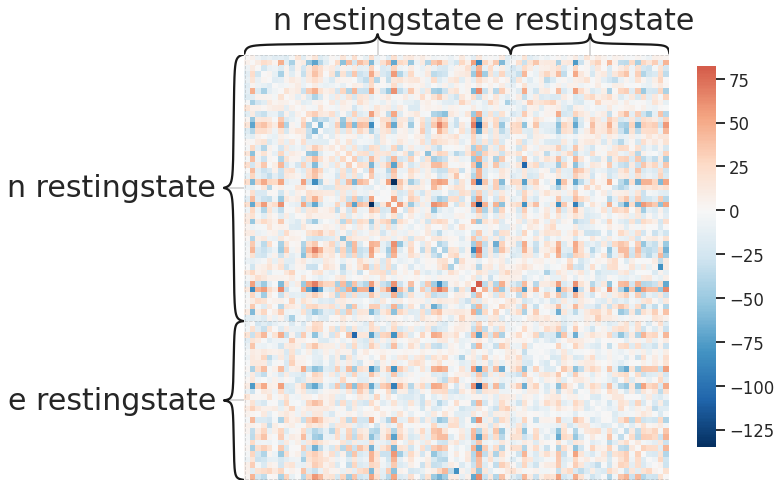

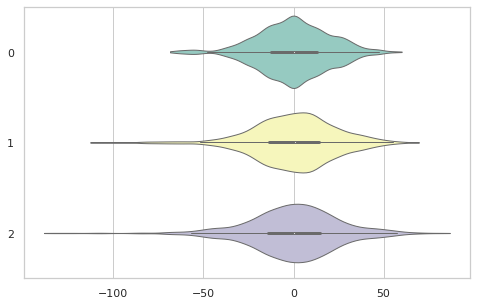

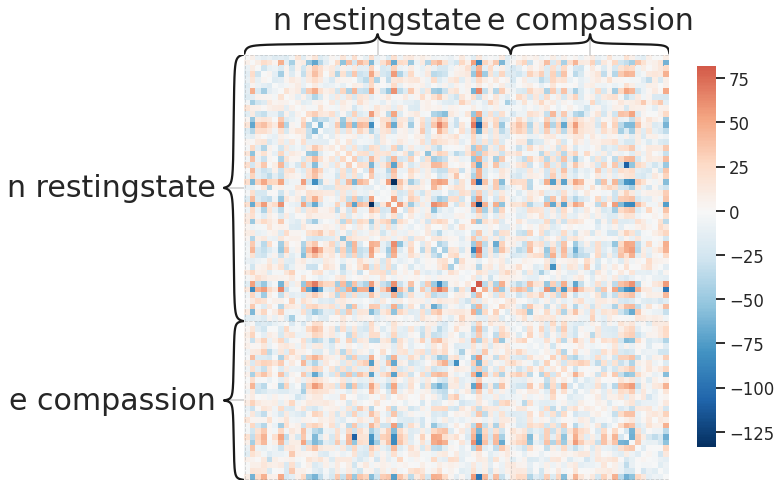

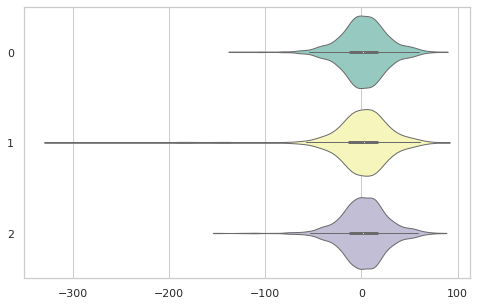

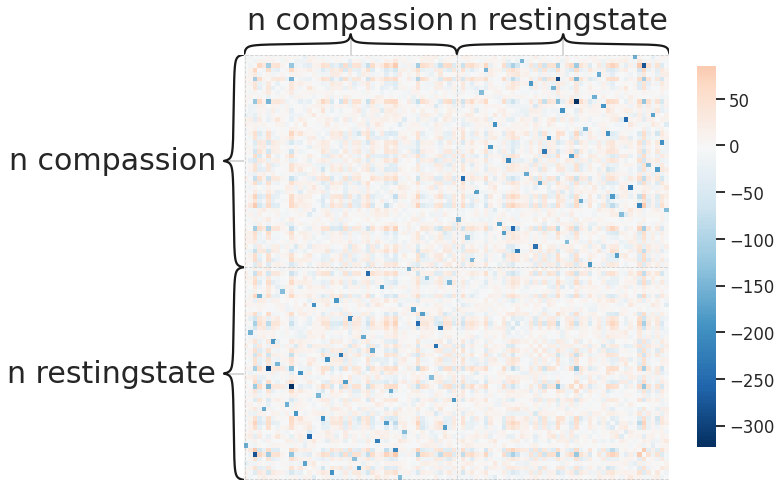

In [79]:
sns.set(style="whitegrid")

for i,j in group_pairs:
    l1,l2 = ' '.join(labels[i]), ' '.join(labels[j])
    g1,g2 = groups[i], groups[j]
    X = np.vstack((g1,g2))[:,:,gradient]
    X_dists = pairwise_distances(X)
    X_dists = center_distmat(X_dists)
    
    q1 = X_dists[:len(g1), :len(g1)].flatten()
    q2 = X_dists[:len(g1), len(g1):].flatten()
    q3 = X_dists[len(g1):, len(g1):].flatten()
    
    f, ax = plt.subplots(figsize=(8,5))
    sns.violinplot(data=[q1,q2,q3], orient="h", palette="Set3", bw=.2, cut=1, linewidth=1)
    plt.show()
    
    heatmap(X_dists, inner_hier_labels = [l1]*len(g1) + [l2]*len(g2))
    plt.show()

In [80]:
gradient = 0

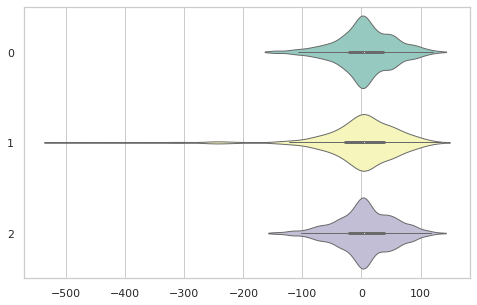

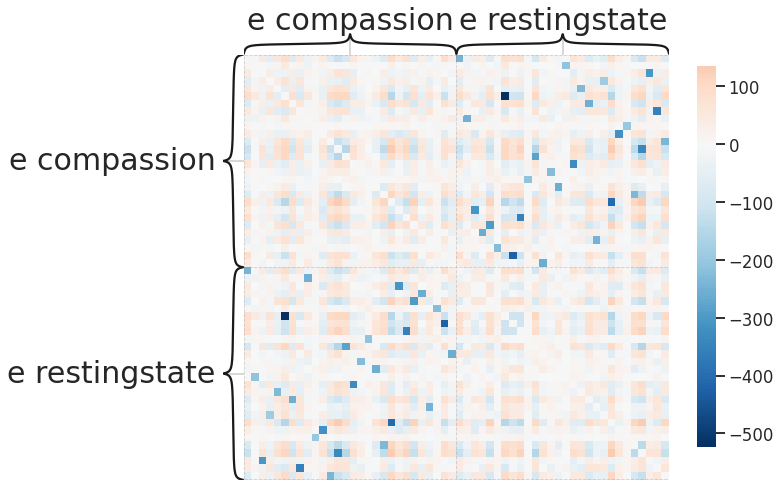

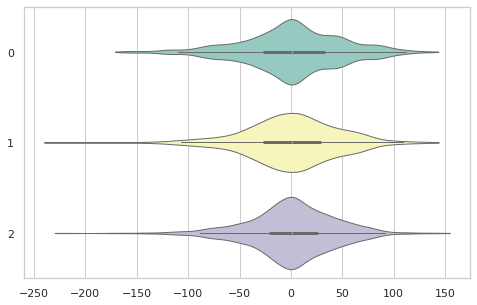

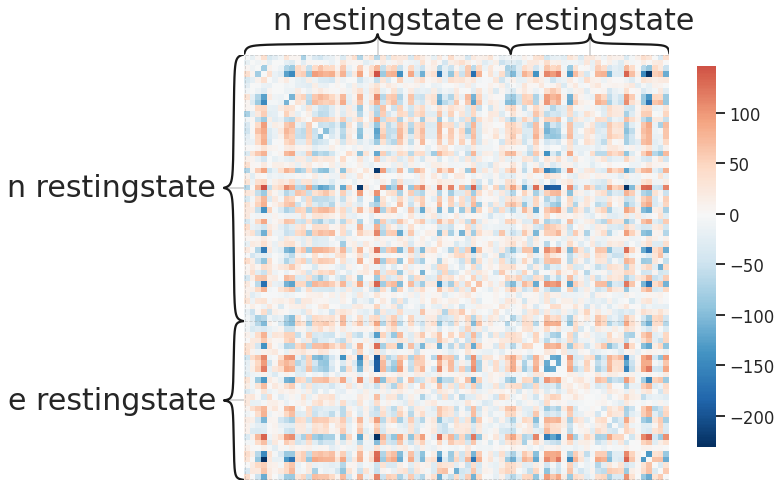

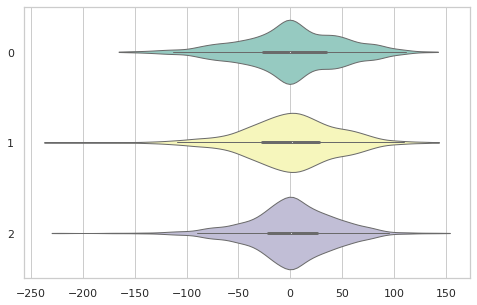

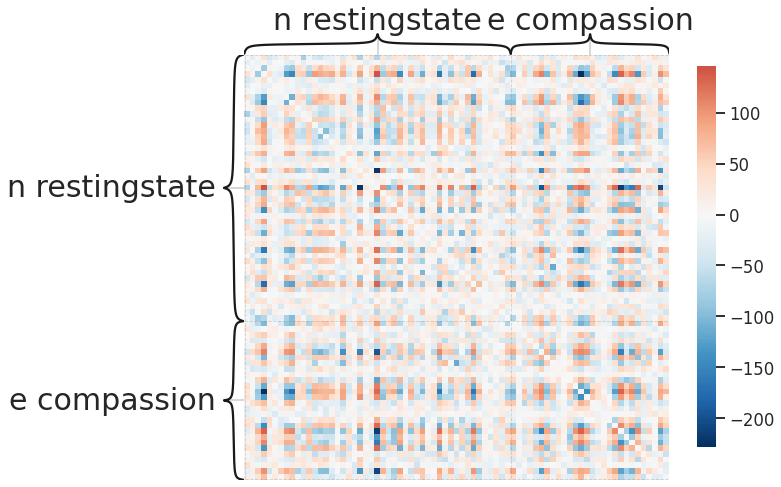

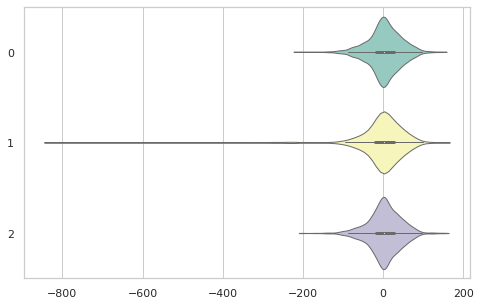

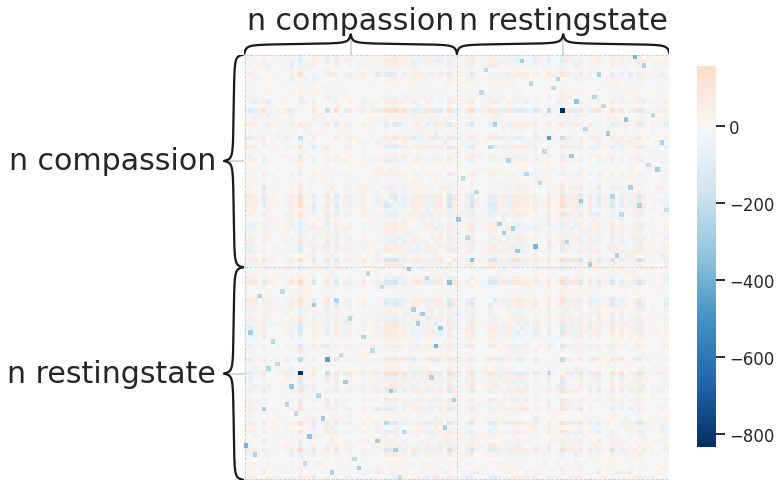

In [81]:
sns.set(style="whitegrid")

for i,j in group_pairs:
    l1,l2 = ' '.join(labels[i]), ' '.join(labels[j])
    g1,g2 = groups[i], groups[j]
    X = np.vstack((g1,g2))[:,:,gradient]
    X_dists = pairwise_distances(X)
    X_dists = center_distmat(X_dists)
    
    q1 = X_dists[:len(g1), :len(g1)].flatten()
    q2 = X_dists[:len(g1), len(g1):].flatten()
    q3 = X_dists[len(g1):, len(g1):].flatten()
    
    f, ax = plt.subplots(figsize=(8,5))
    sns.violinplot(data=[q1,q2,q3], orient="h", palette="Set3", bw=.2, cut=1, linewidth=1)
    plt.show()
    
    heatmap(X_dists, inner_hier_labels = [l1]*len(g1) + [l2]*len(g2))
    plt.show()